# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

Results using hyperparameters from below:
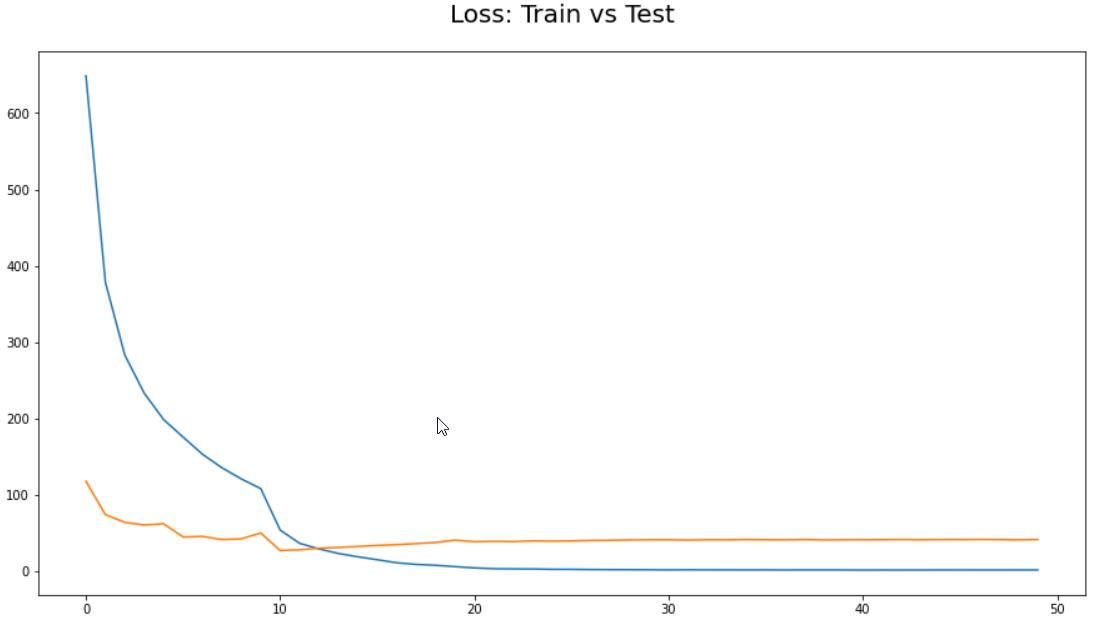

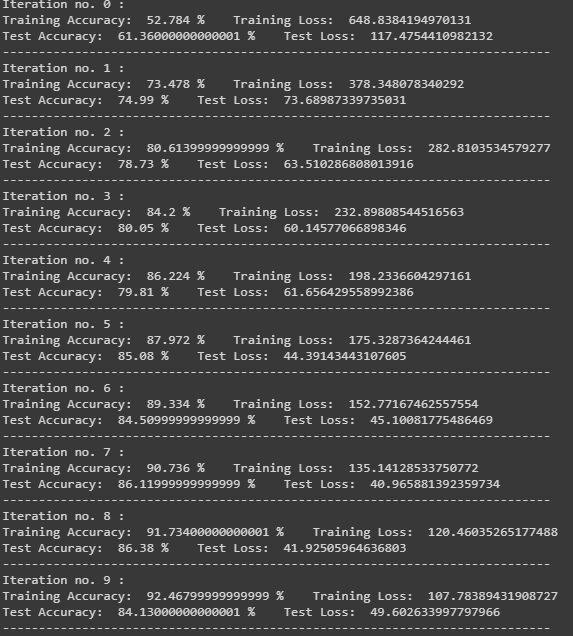
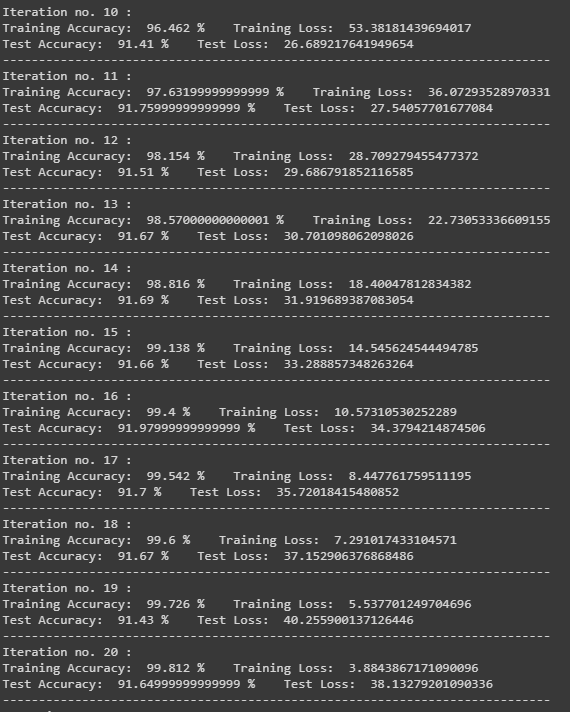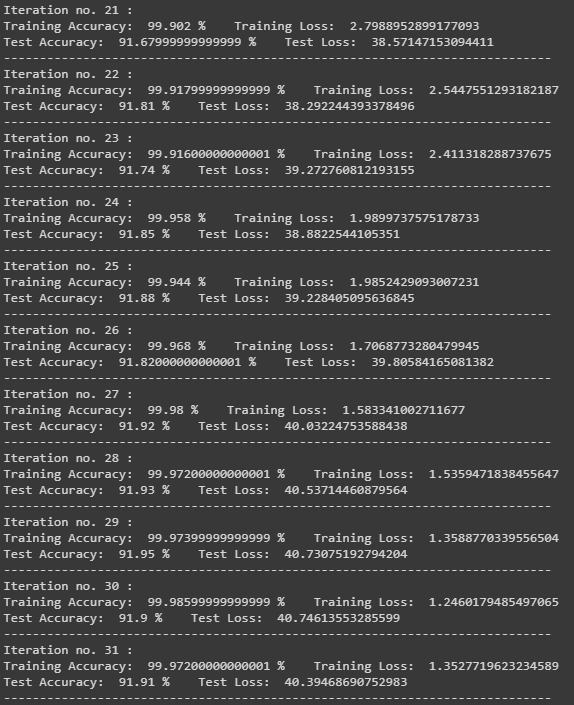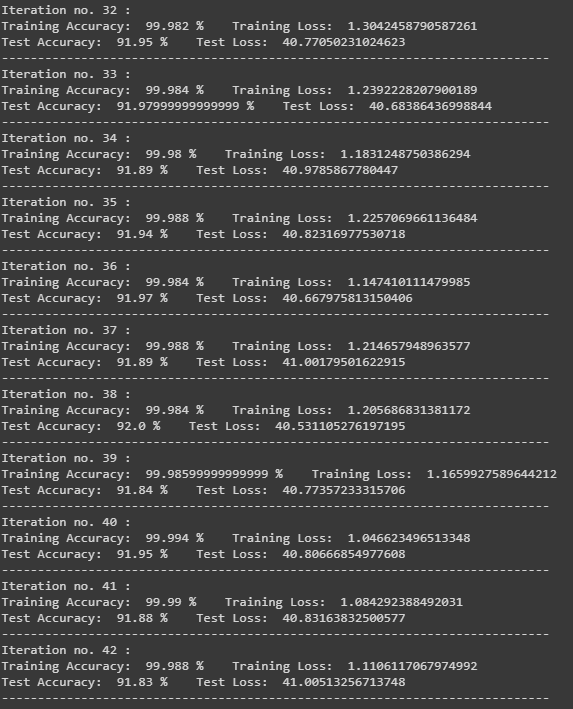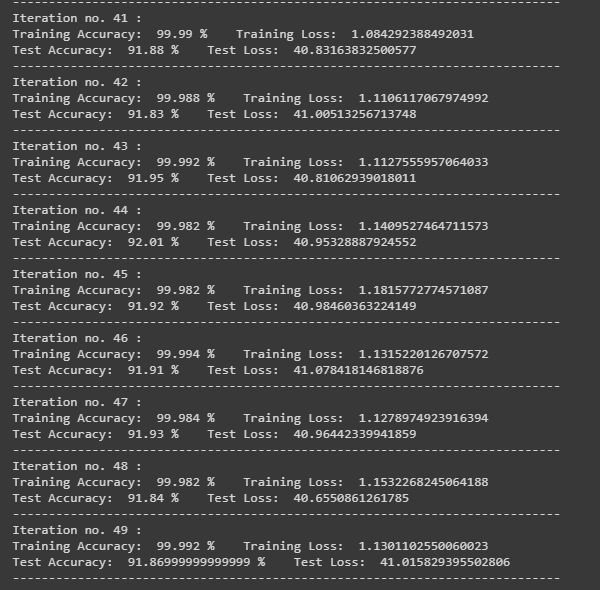

-----
# Goals
A goal is to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [ ]:
from __future__ import division
import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data
from ipywidgets import IntProgress

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [ ]:
if torch.cuda.is_available():
    currentDevice = torch.device('cuda')
    print("CUDA on. Working with GPU...")
else:
    currentDevice = torch.device('cpu')
    print("CUDA off. Working with CPU...")

CUDA on. Working with GPU...


-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. numbper of epoches
5. out put directory

In [ ]:
learningRate =  0.001
batchSizeTrain = 100
batchSizeTest = 100
epochesNumber = 50

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [ ]:
if os.path.exists('./data') == False:
    os.makedirs('./data')

-----
##  Data Loading
Next, we are going to load our data. 
### We need to prepare our data:

### We first import necessary librarys for data loading

In [ ]:
# all libraries imported at the top

-----
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testting set. Note that the testing spilit do not require any transform

In [ ]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [ ]:
train_set = dset.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = data.DataLoader(dataset=train_set, batch_size=batchSizeTrain, shuffle=True)
test_set = dset.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = data.DataLoader(dataset=test_set, batch_size=batchSizeTest, shuffle=False)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


-----
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paper below to understand the structure.
### https://arxiv.org/abs/1409.4842



------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of tow 2D convaluations, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of three 2D convaluations, three 2D batch normalization layers and three ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
              nn.Conv2d(in_planes, kernel_3_in, kernel_size = 1),
              nn.BatchNorm2d(kernel_3_in),
              nn.ReLU(True),
              nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size = 3, padding = 1),
              nn.BatchNorm2d(kernel_3_x),
              nn.ReLU(True)
          )


        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
          nn.Conv2d(in_planes, kernel_5_in, kernel_size = 1),
          nn.BatchNorm2d(kernel_5_in),
          nn.ReLU(True),
          nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(kernel_5_x),
          nn.ReLU(True),
          nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(kernel_5_x),
          nn.ReLU(True)
      )
         

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
          nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
          nn.Conv2d(in_planes, pool_planes, kernel_size = 1),
          nn.BatchNorm2d(pool_planes),
          nn.ReLU(True)
      )
      
       

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], 1)


-----
### GoogLeNet Module (There exist many implement methods)


1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convaluation with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    3. Two Inception block
    
    4. Maxpooling layer
    
    5. Seven Inception block
    
    6. Average Pooling layer
    
    7. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [ ]:

class GoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.inception0 = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(192),
            nn.ReLU(True)
        )
        
        self.inception1 = Inception(192, 64, 96, 128, 16, 32, 32)
        
        self.inception2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.inception3 = Inception(480, 192, 96, 208, 16, 48, 64)
        
        self.inception4 = Inception(512, 160, 112, 224, 24, 64, 64)
        
        self.inception5 = Inception(512, 128, 128, 256, 24, 64, 64)
        
        self.inception6 = Inception(512, 112, 144, 288, 32, 64, 64)
        
        self.inception7 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        self.inception8 = Inception(832, 256, 160, 320, 32, 128, 128)
        
        self.inception9 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        self.maxPooling = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.avgPooling = nn.AvgPool2d(kernel_size = 3)
        
        self.full_cnnctd = nn.Linear(1024, 10)
        
    def forward(self, x):
        
        x = self.inception0(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.maxPooling(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.inception7(x)
        x = self.maxPooling(x)
        x = self.inception8(x)
        x = self.inception9(x)
        x = self.maxPooling(x)
        x = self.avgPooling(x) 
        x = self.full_cnnctd(x.view(x.size(0), -1))
        return x


### Next, we create the network and send it to the target device

In [ ]:
cnn = GoogLeNet()
cnn = cnn.to(device = currentDevice)

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [ ]:
cnnOptimizer = torch.optim.Adam(cnn.parameters())
cnnCriterion = nn.CrossEntropyLoss()
cnnScheduler = torch.optim.lr_scheduler.StepLR(cnnOptimizer, step_size=10)

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [ ]:
if os.path.exists('./models') == False:
    os.makedirs('./models')

def train():
    
    cnn.train()
    trainLoss = 0
    correct = 0
    total = 0

    for batch, (data, target) in enumerate(train_loader):
        data, target = data.to(device = currentDevice), target.to(device = currentDevice)
        cnnOptimizer.zero_grad()
        output = cnn(data)
        loss = cnnCriterion(output, target)
        loss.backward()
        cnnOptimizer.step()
        
        trainLoss += loss.item()
        _, predictions = output.max(1)
        total += target.size(0)
        correct += predictions.eq(target).sum().item()
        
    trainAccuracy = (correct/total)*100
    print("Training Accuracy: ", trainAccuracy, "%   ", "Training Loss: ", trainLoss)
    
    return trainAccuracy, trainLoss

In [ ]:
def test():

    cnn.eval()
    testLoss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        
        for batch, (data, target) in enumerate(test_loader):
            
            data, target = data.to(device = currentDevice), target.to(device = currentDevice)
            output = cnn(data)
            loss = cnnCriterion(output, target)
            
            testLoss += loss.item()
            _, predictions = output.max(1)
            total += target.size(0)
            correct += predictions.eq(target).sum().item()
            
    testAccuracy = (correct/total)*100     
    print("Test Accuracy: ", testAccuracy, "%   ", "Test Loss: ", testLoss)
    
    return testAccuracy, testLoss

In [ ]:
trainAccuracyList = []
trainLossList = []
testAccuracyList = []
testLossList = []


for now in range(epochesNumber):

    print("Iteration no.", now, ": ")
    trainAccuracyNow, trainLossNow = train()
    trainAccuracyList.append(trainAccuracyNow)
    trainLossList.append(trainLossNow)

    testAccuracyNow, testLossNow = test()
    testAccuracyList.append(testAccuracyNow)
    testLossList.append(testLossNow)

    cnnScheduler.step()
    print("----------------------------------------------------------------------------")



Iteration no. 0 : 
Training Accuracy:  52.784 %    Training Loss:  648.8384194970131
Test Accuracy:  61.36000000000001 %    Test Loss:  117.4754410982132
----------------------------------------------------------------------------
Iteration no. 1 : 
Training Accuracy:  73.478 %    Training Loss:  378.348078340292
Test Accuracy:  74.99 %    Test Loss:  73.68987339735031
----------------------------------------------------------------------------
Iteration no. 2 : 
Training Accuracy:  80.61399999999999 %    Training Loss:  282.8103534579277
Test Accuracy:  78.73 %    Test Loss:  63.510286808013916
----------------------------------------------------------------------------
Iteration no. 3 : 
Training Accuracy:  84.2 %    Training Loss:  232.89808544516563
Test Accuracy:  80.05 %    Test Loss:  60.14577066898346
----------------------------------------------------------------------------
Iteration no. 4 : 
Training Accuracy:  86.224 %    Training Loss:  198.2336604297161
Test Accuracy:  7

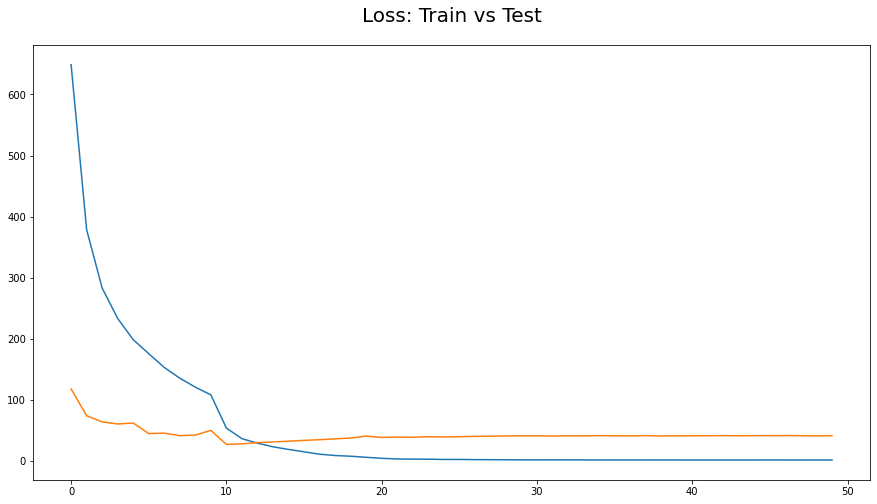

Highest test accuracy is:  92.01
Best epoch is:  44


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 8))

plt.plot(list(range(epochesNumber)), trainLossList, label = "Train")
plt.plot(list(range(epochesNumber)), testLossList, label = "Test")
plt.title("Loss: Train vs Test", fontsize=20, y=1.04)
plt.show()

torch.save(cnn.state_dict(), "./models/state_dict_model.pth")
    
maxAccuracy = np.max(testAccuracyList)
optEpoch = np.argmax(testAccuracyList)

print("Highest test accuracy is: ", maxAccuracy)
print("Best epoch is: ", optEpoch)